<a href="https://colab.research.google.com/github/Nadian-Ali/GeoImageClassificaiton/blob/main/train_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#what is 236?  got it!

#same rock / different depth / different pattern /// same class? or two classes? 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive'


/content/drive/My Drive


In [3]:
import os 
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow



In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [4]:

Alis = 'Projects/GeoSampleClassification/data'
folder_location_in_drive= os.path.join(os.getcwd(),Alis)

file_names = [f for f in listdir(folder_location_in_drive) if( f.split('.')[-1]=='las' and isfile(join(folder_location_in_drive, f)))] #get list of the files with las extension 


In [12]:

# the FMI_reader function reads the .las files that contain FMI resistivity values.
# the output of the function is two numpy arrays 
#1. data which is 2D array with 192 colums and rows equal to the number of depth samples 
#2. the depth array which is a 1D array and contains all the depth
# samples
def FMI_reader(path):
    # f = open(path, 'r')
    # content = f.readlines()
    # f.close()
    with open(path,'r') as file:
      content  = file.readlines()
    data = []
    depth = []
    rock_type = path.split('.')[0].split('_')[0].split('/')[-1]
    for L in content:
        L = L.split(' ')
        res = [st for st in L if st != "" and st != '\n']
        if res[0] == '~Ascii':
            continue
        elif res[0] == '~Version':
            break
        elif len(res) == 1:
            depth.append(float(res[0]))
        else:
            data.extend(list(map(float, res)))

    data = np.array(data)
    depth = np.array(depth)
    data = np.reshape(data, (-1, 192))

    return data, depth, rock_type

In [17]:
Data = []
Depth = []
Rock_Type = []

for file in file_names:
  path = os.path.join( os.path.join(os.getcwd(),Alis,file))
  print(path)
  if 'full' not in path:
      
    # print(path)
    # path = '/content/drive/MyDrive/Projects/GeoSampleClassification/data/SstLoa_1.las'
    data,depth,rock_type = FMI_reader(path)
    Data.append(data)
    Depth.append(depth)
    Rock_Type.append(rock_type)
    # cv2_imshow(data)
    print(np.shape(data))
    # print(rock_type)
    # cv2_imshow(data)
    # print(rock_type)

/content/drive/MyDrive/Projects/GeoSampleClassification/data/SstLoa_1.las
(236, 192)
/content/drive/MyDrive/Projects/GeoSampleClassification/data/SstLoa_2.las
(393, 192)
/content/drive/MyDrive/Projects/GeoSampleClassification/data/SstHia_1.las
(472, 192)
/content/drive/MyDrive/Projects/GeoSampleClassification/data/SstHia_2.las
(433, 192)
/content/drive/MyDrive/Projects/GeoSampleClassification/data/CemtLa_1.las
(276, 192)
/content/drive/MyDrive/Projects/GeoSampleClassification/data/CemtLa_2.las
(40, 192)
/content/drive/MyDrive/Projects/GeoSampleClassification/data/HetLoc_1.las
(314, 192)
/content/drive/MyDrive/Projects/GeoSampleClassification/data/HetLoc_2.las
(314, 192)
/content/drive/MyDrive/Projects/GeoSampleClassification/data/HetHic_2.las
(117, 192)
/content/drive/MyDrive/Projects/GeoSampleClassification/data/HetHic_1.las
(314, 192)
/content/drive/MyDrive/Projects/GeoSampleClassification/data/full_image_crc2.las


In [7]:
print('The samples in Data and Rock_Type are {} and {} respectively'.format(len(Data),len(Rock_Type)))

The samples in Data and Rock_Type are 10 and 10 respectively


In [8]:
Rock_Type

['SstLoa',
 'SstLoa',
 'SstHia',
 'SstHia',
 'CemtLa',
 'CemtLa',
 'HetLoc',
 'HetLoc',
 'HetHic',
 'HetHic']

In [18]:
classes = ['SstLoa', 'SstHia','CemtLa','HetLoc','HetHic']
cls = {Key:Label for Label,Key in enumerate(classes)}
Dta = np.array(Data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


numpy.ndarray

<h1> Create new dataset</h1>

In [19]:
num_samples = 10
offset  = 192 
IM_Size = 192
def create_sample(im,IM_SIZE):
  rng = np.random.default_rng()
  indexable = np.shape(im)[0]- np.shape(im)[1]
  # print)
  if indexable <= 0:

    # print(indexable)
    im = np.pad(im,((0,abs(indexable)),(0,0)), mode = 'reflect')
    indexable = np.shape(im)[0]- np.shape(im)[1]
    idx = 0
    img = np.array(im[idx:idx+IM_SIZE,:])
    # random x rolling 
    rots = rng.choice(range(IM_SIZE),size = 2, replace = True)
    img = np.roll(img,rots[0],axis = 0)
    img = np.roll(img,rots[1],axis = 1)
    return img, indexable

 
  idx = rng.choice(range(indexable))
  # print(idx)
  rots = rng.choice(range(IM_SIZE),size = 2, replace = True)
  # print(rots)

  #sample data based on index to create IM_size,IM_size sample
  img = np.array(im[idx:idx+IM_SIZE,:])
  # random x rolling 
  img = np.roll(img,rots[0],axis = 0)
  img = np.roll(img,rots[1],axis = 1)
  return img, indexable


In [40]:
SAMPLES = 40
IM_SIZE = 192
X = []
lable = []
for idx,a_sample in enumerate(Dta):
  # print(idx)
  lbl = cls[Rock_Type[idx]]
  for s in range(SAMPLES):
    sample ,IDX = create_sample(a_sample,IM_SIZE)
    # print("\n")
    # cv2_imshow(sample)
    s = np.expand_dims(np.array(sample),axis=0)
    s = np.moveaxis(s,0,-1)
    # print(np.shape(s))
    X.append(s)

    lable.append(lbl)

    
  
X = np.array(X)
y = lable
clses = tf.keras.utils.to_categorical(np.array(y), num_classes=None, dtype="float32")

In [41]:


print('number of smaple is {} and num of lables is {}'.format(np.shape(X),len(clses)))

number of smaple is (400, 192, 192, 1) and num of lables is 400


In [47]:
input = (IM_SIZE,IM_SIZE,1)
inputs = tf.keras.Input(shape = input)
x = layers.Conv2D(2,	 kernel_size=(3,3), 	 activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(4,	 kernel_size=(3,3), 	 activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(8,	 kernel_size=(3,3), 	 activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
# x = layers.Dropout(.5)(x)
# x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(.5)(x)
y = layers.Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=y)





In [48]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 192, 192, 1)]     0         
                                                                 
 conv2d_17 (Conv2D)          (None, 190, 190, 8)       80        
                                                                 
 batch_normalization_17 (Bat  (None, 190, 190, 8)      32        
 chNormalization)                                                
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 95, 95, 8)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 72200)             0         
                                                                 
 dropout_7 (Dropout)         (None, 72200)             0   

In [49]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    # beta_1=0.9,
    # beta_2=0.999,
    # epsilon=1e-07,
    # amsgrad=False,
    name="Adam",
    # **kwargs
)
model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              
              metrics=['accuracy'])


history = model.fit(X,clses,
  epochs=20,
  batch_size=4,
  validation_split = .1,
  shuffle = True,
  )
# accuracy evaluation
# score = model.evaluate(x_test,
#   y_test,
#   batch_size=batch_size,
#   verbose=0)
# print("nTest accuracy: %.1f%%" % (100.0 * score[1]))

Epoch 1/20
90/90 [==============================] - 7s 72ms/step - loss: 9.8972 - accuracy: 0.5750 - val_loss: 60.2788 - val_accuracy: 0.0500
Epoch 2/20
90/90 [==============================] - 6s 68ms/step - loss: 4.4705 - accuracy: 0.7917 - val_loss: 11.2270 - val_accuracy: 0.6250
Epoch 3/20
90/90 [==============================] - 6s 67ms/step - loss: 0.9591 - accuracy: 0.9139 - val_loss: 7.4411 - val_accuracy: 0.7500
Epoch 4/20
90/90 [==============================] - 6s 67ms/step - loss: 0.7742 - accuracy: 0.9472 - val_loss: 18.0898 - val_accuracy: 0.5000
Epoch 5/20
90/90 [==============================] - 6s 67ms/step - loss: 0.4732 - accuracy: 0.9611 - val_loss: 23.5674 - val_accuracy: 0.4750
Epoch 6/20
90/90 [==============================] - 6s 67ms/step - loss: 0.4042 - accuracy: 0.9611 - val_loss: 14.1399 - val_accuracy: 0.5500
Epoch 7/20
90/90 [==============================] - 6s 67ms/step - loss: 0.3105 - accuracy: 0.9750 - val_loss: 28.9988 - val_accuracy: 0.4750
Epoch 8

<h1>Curves </h1>

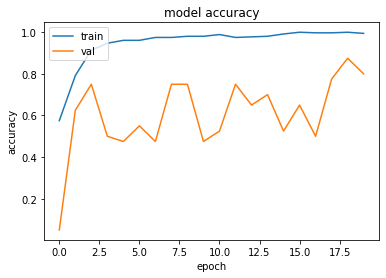

In [50]:
from matplotlib import pyplot as plt
# history = model.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

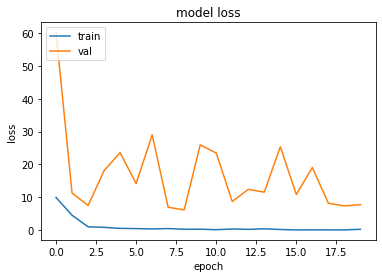

In [51]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

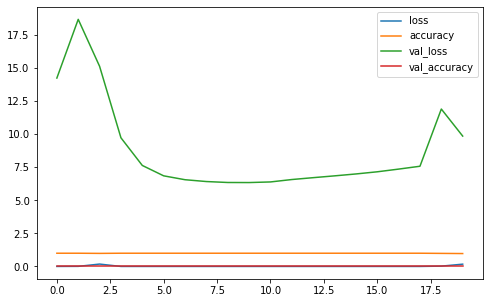

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

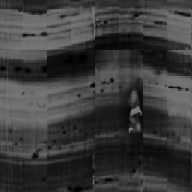

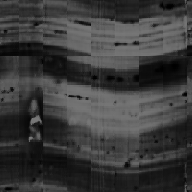

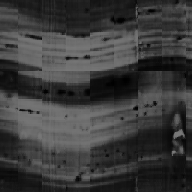

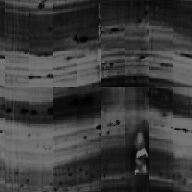

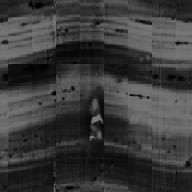

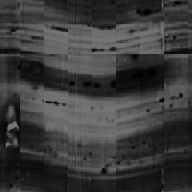

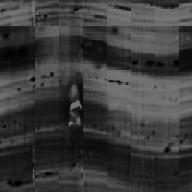

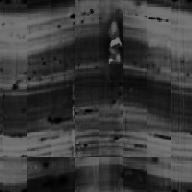

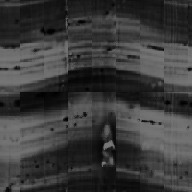

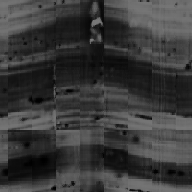

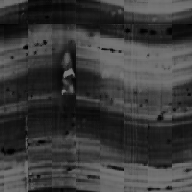

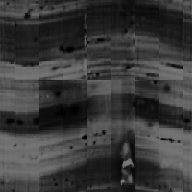

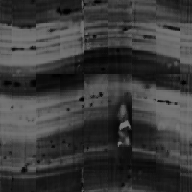

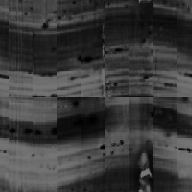

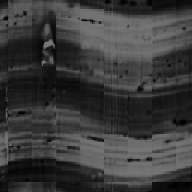

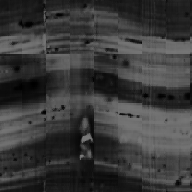

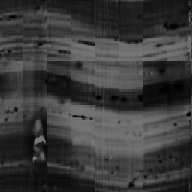

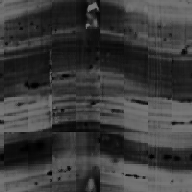

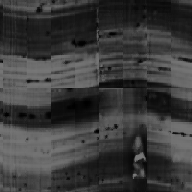

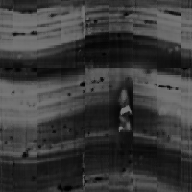

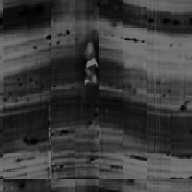

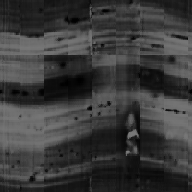

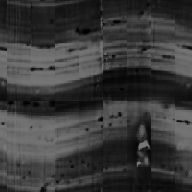

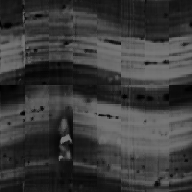

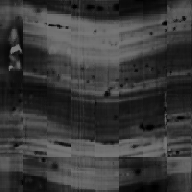

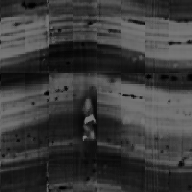

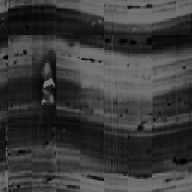

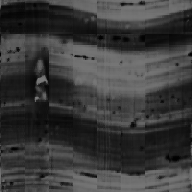

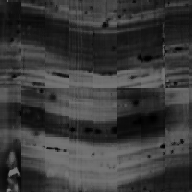

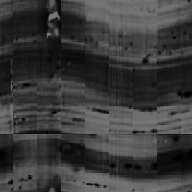

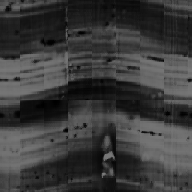

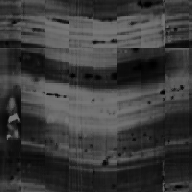

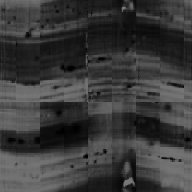

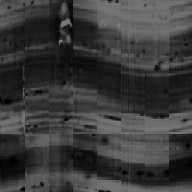

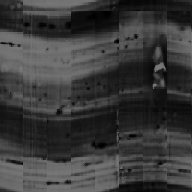

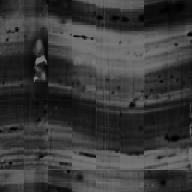

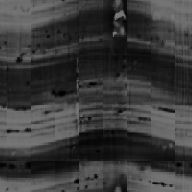

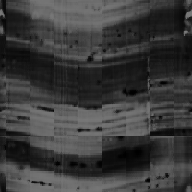

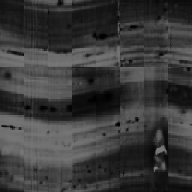

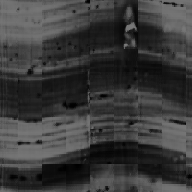

In [53]:
#get samples for one class as an example
SAMPLES = 40
IM_SIZE = 192
X = []
lable = []
idx = 0
a_sample = Dta[idx]
lbl = cls[Rock_Type[idx]]
for s in range(SAMPLES):
  sample ,IDX = create_sample(a_sample,IM_SIZE)
  print("\n")
  cv2_imshow(sample)
  X.append(np.expand_dims(np.array(sample),axis=0))
  lable.append(lbl)

In [54]:


# dataset = np 
# # labels = 
# # create a new sample 
# # indicator i points to both the data , label 
# i = 0
# sample = Dta[i]
# label  = cls[Rock_Type[i]]
# print('the number of rows in this sample is {}'.format(np.shape(sample)))
# # the number of indexs we can select from is : 
# indexable_samples = np.shape(sample)[0] - np.shape(sample)[1]
# print('indexable_samples equals : {}'.format(indexable_samples)) 


# # random.Generator.choice(a, size=None, replace=True, p=None, axis=0, shuffle=True)
# rng = np.random.default_rng()
# samples = rng.choice(range(indexable_samples),size=num_samples,replace = False)

# for _ in samples:

#   sampled_image = Dta[i][_:_+offset] 

#   rot = rng.choice(range(IM_Size))
#   sampled_image = np.roll(sampled_image,rot,axis = 0)
#   sampled_image = np.roll(sampled_image,rot,axis = 1)
#   cv2_imshow(sampled_image)
#   print('\n')
# # np.random.Generator.choice(range(10, 13),size=10)



# # cv2_imshow(sample[:192,:])

In [ ]:
# random.Generator.choice(a, size=None, replace=True, p=None, axis=0, shuffle=True)
rng = np.random.default_rng()
indexed_samples = rng.choice(range(44),size=10,replace = False)
offset = 192 
for K in indexed_samples:
  sampled_image = Dta[i][K:K+offset] 
  cv2_imshow(sampled_image)
  print('\n')
# np.random.Generator.choice(range(10, 13),size=10)

In [ ]:
abs(-2)

2